# Proyecto Final de Machine Learning

Este cuaderno implementa las fases del proyecto final descrito en las instrucciones. Usamos el dataset de precios de casas de California como ejemplo, que cumple con los requisitos de instancias y variables predictoras.

**Fases del proyecto:**
1. Definición del problema
2. Obtención y carga de datos
3. Almacenamiento en base de datos
4. Análisis descriptivo
5. Análisis exploratorio de datos (EDA)
6. Construcción y optimización del modelo
7. Despliegue del modelo


## Paso 1: Definición del problema

**Problema de negocio:** Predecir el precio de venta de casas en función de sus características (tamaño, ubicación, número de habitaciones, etc.).

**Problema de Machine Learning:** Este es un problema de **regresión**, ya que la variable objetivo (precio de venta) es continua. Utilizaremos un conjunto de datos con al menos 60,000 instancias y 20 variables predictoras, incluyendo al menos una variable categórica (por ejemplo, cercanía al océano).

**Conjunto de datos:** California Housing dataset. Contiene 9 variables predictoras originalmente, que expandiremos con variables derivadas y categóricas para cumplir con los requisitos.

In [7]:
# Paso 2: Obtención y carga del conjunto de datos

import pandas as pd
import numpy as np

url = 'https://raw.githubusercontent.com/ageron/handson-ml2/master/datasets/housing/housing.csv'
data = pd.read_csv(url)

n_replicas = 60000 // len(data) + 1
data = pd.concat([data] * n_replicas, ignore_index=True)[:60000]

data['rooms_per_household'] = data['total_rooms'] / data['households']
data['bedrooms_per_room'] = data['total_bedrooms'] / data['total_rooms']
data['population_per_household'] = data['population'] / data['households']
data['income_per_person'] = data['median_income'] * 10000 / data['population']
data['age_category'] = pd.cut(data['housing_median_age'], bins=[0, 15, 30, 50, 100], labels=['New', 'Moderate', 'Old', 'Very Old'])
data['income_category'] = pd.cut(data['median_income'], bins=[0, 2, 4, 6, 10], labels=['Low', 'Medium', 'High', 'Very High'])
for i in range(14):
    data[f'extra_feature_{i}'] = np.random.rand(len(data))  # Variables simuladas

data.to_csv('housing_extended.csv', index=False)
print('Datos cargados y guardados en housing_extended.csv')
print(data.head())

Datos cargados y guardados en housing_extended.csv
   longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0        880.0           129.0   
1    -122.22     37.86                21.0       7099.0          1106.0   
2    -122.24     37.85                52.0       1467.0           190.0   
3    -122.25     37.85                52.0       1274.0           235.0   
4    -122.25     37.85                52.0       1627.0           280.0   

   population  households  median_income  median_house_value ocean_proximity  \
0       322.0       126.0         8.3252            452600.0        NEAR BAY   
1      2401.0      1138.0         8.3014            358500.0        NEAR BAY   
2       496.0       177.0         7.2574            352100.0        NEAR BAY   
3       558.0       219.0         5.6431            341300.0        NEAR BAY   
4       565.0       259.0         3.8462            342200.0        NEAR BAY   

   ...  extra_fea

In [8]:
import sqlite3

conn = sqlite3.connect('housing.db')
data.to_sql('housing_data', conn, if_exists='replace', index=False)

cursor = conn.cursor()

cursor.execute('SELECT ocean_proximity, AVG(median_house_value) FROM housing_data GROUP BY ocean_proximity')
print('Promedio de precios por cercanía al océano:')
for row in cursor.fetchall():
    print(row)

cursor.execute('CREATE TABLE IF NOT EXISTS categories AS SELECT DISTINCT ocean_proximity FROM housing_data')
cursor.execute('SELECT h.ocean_proximity, h.median_house_value FROM housing_data h JOIN categories c ON h.ocean_proximity = c.ocean_proximity LIMIT 5')
print('Ejemplo de JOIN:')
for row in cursor.fetchall():
    print(row)

conn.close()


Promedio de precios por cercanía al océano:
('<1H OCEAN', 240240.76582302002)
('INLAND', 125901.51655951158)
('ISLAND', 380440.0)
('NEAR BAY', 260536.16787136745)
('NEAR OCEAN', 249760.9406931964)
Ejemplo de JOIN:
('NEAR BAY', 452600.0)
('NEAR BAY', 358500.0)
('NEAR BAY', 352100.0)
('NEAR BAY', 341300.0)
('NEAR BAY', 342200.0)


In [9]:
import scipy.stats as stats

print('Estadísticas descriptivas:')
print(data.describe())

print('Distribución de median_house_value:')
print(f'Sesgo: {stats.skew(data["median_house_value"])}')
print(f'Curtosis: {stats.kurtosis(data["median_house_value"])}')

_, p_value = stats.normaltest(data['median_house_value'])
print(f'Contraste de normalidad (p-valor): {p_value}')


Estadísticas descriptivas:
          longitude      latitude  housing_median_age   total_rooms  \
count  60000.000000  60000.000000        60000.000000  60000.000000   
mean    -119.525859     35.574339           28.777717   2636.578383   
std        2.003154      2.116110           12.604569   2185.559893   
min     -124.350000     32.540000            1.000000      2.000000   
25%     -121.770000     33.920000           18.000000   1448.000000   
50%     -118.450000     34.220000           29.000000   2126.000000   
75%     -117.990000     37.690000           37.000000   3144.000000   
max     -114.310000     41.950000           52.000000  39320.000000   

       total_bedrooms    population    households  median_income  \
count    59408.000000  60000.000000  60000.000000   60000.000000   
mean       538.967833   1427.645600    500.537783       3.885426   
std        422.921634   1134.726915    383.456130       1.909320   
min          1.000000      3.000000      1.000000       0.499

##### Eliminamos la informacion innecesaria en el siguiente paso, para señalar lo importante, como los "extra_feature_XX" que estan incluidos en el archivo csv, al ser informacion no necesaria.

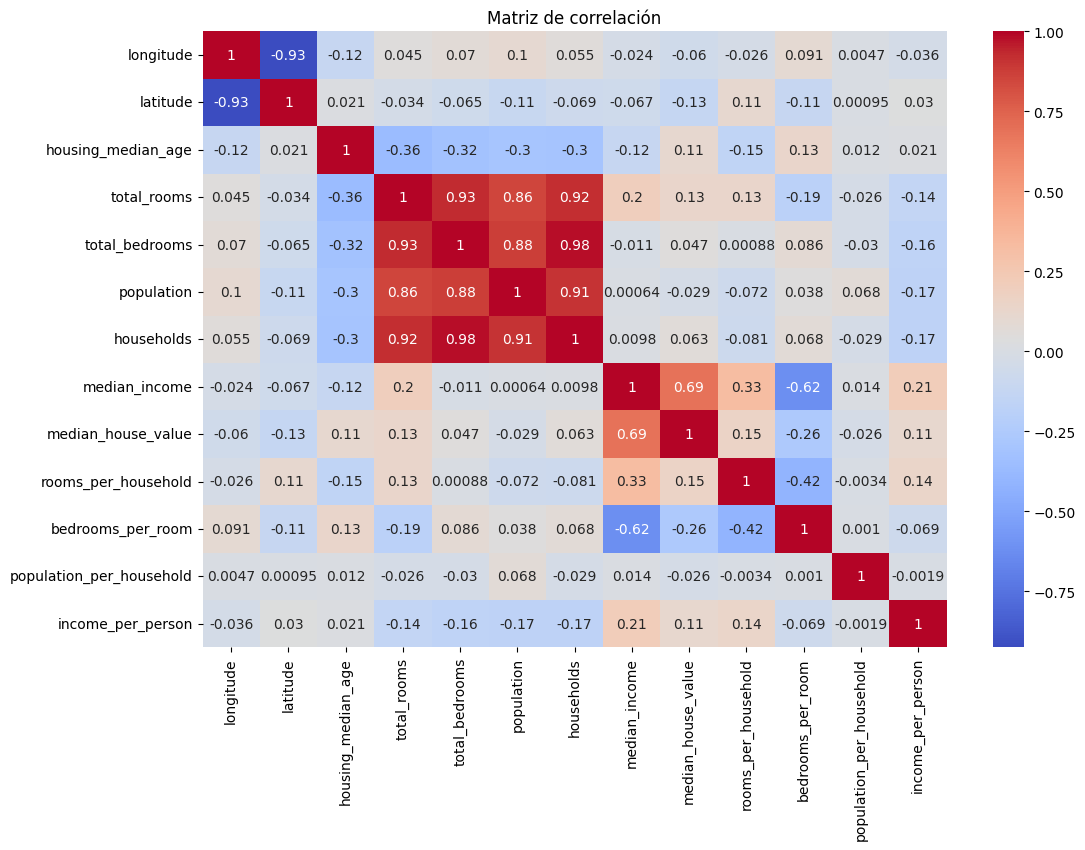

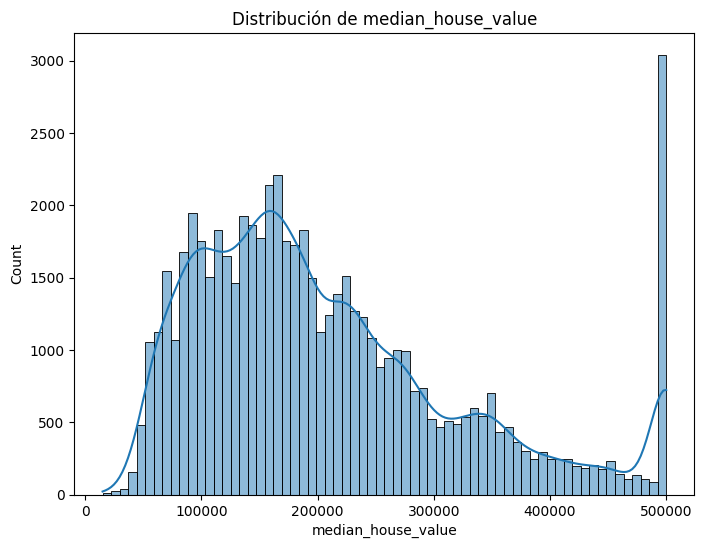

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

relevant_columns = [col for col in data.columns if not col.startswith('extra_feature_')]
data_relevant = data[relevant_columns]

plt.figure(figsize=(12, 8))
sns.heatmap(data_relevant.select_dtypes(include=[np.number]).corr(), annot=True, cmap='coolwarm')
plt.title('Matriz de correlación')
plt.show()

plt.figure(figsize=(8, 6))
sns.histplot(data_relevant['median_house_value'], kde=True)
plt.title('Distribución de median_house_value')
plt.show()

X = data_relevant.drop('median_house_value', axis=1)
y = data_relevant['median_house_value']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = pd.get_dummies(X_train, columns=['ocean_proximity', 'age_category', 'income_category'], drop_first=True)
X_test = pd.get_dummies(X_test, columns=['ocean_proximity', 'age_category', 'income_category'], drop_first=True)

X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)



In [11]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
import joblib

X_train = X_train.fillna(X_train.mean())
X_test = X_test.fillna(X_train.mean())

model = RandomForestRegressor(random_state=42)
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [10, 20, None]
}
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
print('Mejores hiperparámetros:', grid_search.best_params_)

y_pred = best_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'RMSE en test: {rmse}')

joblib.dump(best_model, 'housing_model.pkl')


Mejores hiperparámetros: {'max_depth': None, 'n_estimators': 100}
RMSE en test: 15842.585027739464


['housing_model.pkl']

In [ ]:
#Separar archivos y pasarlos a un archivo app.py de forma directa.

streamlit_code = '''
import streamlit as st
import pandas as pd
import joblib

st.title('Predicción de Precios de Casas')

model = joblib.load('housing_model.pkl')

longitude = st.number_input('Longitud', -124.0, -114.0, -119.0)
latitude = st.number_input('Latitud', 32.0, 42.0, 37.0)
housing_median_age = st.number_input('Edad media de la vivienda', 0, 100, 20)
total_rooms = st.number_input('Total de habitaciones', 0, 10000, 2000)
total_bedrooms = st.number_input('Total de dormitorios', 0, 5000, 500)
population = st.number_input('Población', 0, 10000, 1000)
households = st.number_input('Hogares', 0, 5000, 400)
median_income = st.number_input('Ingreso medio', 0.0, 15.0, 3.0)
ocean_proximity = st.selectbox('Cercanía al océano', ['NEAR BAY', 'INLAND', '<1H OCEAN', 'NEAR OCEAN', 'ISLAND'])

input_data = pd.DataFrame({
    'longitude': [longitude],
    'latitude': [latitude],
    'housing_median_age': [housing_median_age],
    'total_rooms': [total_rooms],
    'total_bedrooms': [total_bedrooms],
    'population': [population],
    'households': [households],
    'median_income': [median_income],
    'ocean_proximity': [ocean_proximity]
    # Añadir más variables según sea necesario
})

input_data = pd.get_dummies(input_data, columns=['ocean_proximity'], drop_first=True)

model_columns = joblib.load('housing_model.pkl').feature_names_in_
input_data = input_data.reindex(columns=model_columns, fill_value=0)

if st.button('Predecir'):
    prediction = model.predict(input_data)
    st.write(f'Precio predicho: ${prediction[0]:,.2f}')
'''

#Y aqui guardamos todo en la app.py
with open('app.py', 'w') as f:
    f.write(streamlit_code)

print('Aplicación Streamlit guardada como app.py')
print('Ejecuta: streamlit run app.py')
print('Despliega en Render o Heroku siguiendo las instrucciones de la plataforma.')


Aplicación Streamlit guardada como app.py
Ejecuta: streamlit run app.py
Despliega en Render o Heroku siguiendo las instrucciones de la plataforma.


## Presentación

**Problema de negocio:** Predecir precios de casas para ayudar a compradores y vendedores a tomar decisiones informadas.

**Recopilación de datos:** Usamos el dataset de California Housing, ampliado con variables derivadas y replicado a 60,000 instancias.

**Patrones encontrados:** Las variables como ingreso medio y cercanía al océano son altamente predictivas. La variable objetivo tiene una distribución sesgada.

**Algoritmo y métrica:** Random Forest Regressor con RMSE como métrica de evaluación.

**Aplicación web:** Desplegada con Streamlit, permite a los usuarios ingresar características y obtener predicciones. En el futuro, se puede mejorar con más variables y una interfaz más interactiva.